In [1]:
from build_dataset import create_dataloader
from models import *
from main import get_args
import torch.nn as nn
import torch
import numpy as np

from transformers import GPT2Tokenizer, GPT2Model, GPT2Config

from utils import convert_device, load_checkpoint

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os

In [2]:
def convert_batch1(tokenizer, captions, frames, seg_features, tsn_features):
    captions = {'input_ids':torch.tensor([tokenizer.encode(captions)])}
    
    frames['boundary'] = frames['boundary'].unsqueeze(0)
    frames['before'] = frames['before'].unsqueeze(0)
    frames['after'] = frames['after'].unsqueeze(0)

    seg_features['boundary'] = seg_features['boundary'].unsqueeze(0)
    seg_features['before'] = seg_features['before'].unsqueeze(0)
    seg_features['after'] = seg_features['after'].unsqueeze(0)

    tsn_features['before'] = torch.tensor(tsn_features['before']).unsqueeze(0)
    tsn_features['after'] = torch.tensor(tsn_features['after']).unsqueeze(0)

    captions, frames, seg_features, tsn_features = convert_device(captions, args.device), \
                                                   convert_device(frames, args.device), \
                                                   convert_device(seg_features, args.device), \
                                                   convert_device(tsn_features, args.device)
    
    return captions, frames, seg_features, tsn_features

In [3]:
args = get_args(True)
args.yaml_file = '../config/captioning_config.yaml'

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'cls_token':tokenizer.eos_token})

0

In [5]:
args.unimodal_modelname = 'gpt2'
args.multimodal_modelname = 'gpt2'
args.image_modelname = 'vit_large_patch16_224_in21k'
args.batch_size = 2
args.num_img_queries = 16
args.use_frame_position = True
args.use_saved_frame = True
args.use_seg_features = True
args.use_tsn_features = True
args.use_temporal_pairwise_difference = True
args.use_img_encoder_lora = True
args.use_replace_01 = True
args.use_label = True
args.aggregation_frames_method = 'aggregation_frames_method2'

args.device = torch.device('cuda')

In [8]:
model = create_model(args, tokenizer)
model.to(args.device)

Some weights of MultiModalDecoder were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.9.crossattention.q_attn.weight', 'h.0.crossattention.q_attn.weight', 'h.10.ln_cross_attn.weight', 'h.2.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.9.crossattention.q_attn.bias', 'h.0.ln_cross_attn.bias', 'h.4.crossattention.q_attn.weight', 'h.2.crossattention.c_proj.bias', 'h.4.crossattention.c_proj.weight', 'h.7.ln_cross_attn.bias', 'h.10.ln_cross_attn.bias', 'h.8.ln_cross_attn.weight', 'h.8.crossattention.c_proj.bias', 'h.1.ln_cross_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.9.crossattention.bias', 'h.10.crossattention.q_attn.bias', 'h.11.crossattention.q_attn.weight', 'h.3.crossattention.q_attn.weight', 'h.2.crossattention.q_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.6.crossattention.q_attn.weight', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.11.crossattention.masked_bias', 'h.1.crossattention.bi

VideoBoudnaryCoCa(
  (image_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU()
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=4096, out_features=1024, bias=

In [9]:
model = load_checkpoint('./output/VideoBoundaryCoCa_0530-LoRA_img_ft_label/VideoBoundaryCoCa_0530-LoRA_img_ft_label_step1249.pt', model)

load checkpoint from ./output/VideoBoundaryCoCa_0530-LoRA_img_ft_label/VideoBoundaryCoCa_0530-LoRA_img_ft_label_step1249.pt


In [10]:
model.eval()
print('eval mode')

eval mode


In [6]:
dataloader = create_dataloader(args, 'train_val', tokenizer, test_mode=True)

In [36]:
def infer(sample_idx, model, tokenizer, dataloader, args):

    boundary_ids, captions, frames, seg_features, tsn_features = dataloader.dataset[sample_idx]
    captions, frames, seg_features, tsn_features = convert_batch1(tokenizer, captions, frames, seg_features, tsn_features)

    inputs = {
        'frames'       : frames,
        'seg_features' : seg_features,
        'tsn_features' : tsn_features
    }

    output = model.generate(
        inputs, 
        max_length             = args.gen_max_length, 
#         decoder_input_ids      = captions['input_ids'],
        decoder_start_token_id = tokenizer.encode('Subject')[0],    
#         decoder_start_token_id = torch.tensor(tokenizer.encode('Subject: ')).to(args.device), 
        num_beams              = 10,
        num_beam_groups = 5,
    #     top_k = 10,
    #     do_sample = True,
    #     temperature = 1.2,
    )

    print('[Boundary ID]: ',boundary_ids)
    print(tokenizer.batch_decode(output))

    print('[Predicted Caption]')
    for p in tokenizer.batch_decode(output)[0].split('//'):
        print(p)
    print()


    # Ground Truth
    img = frames['boundary'][0].permute(1,2,0).detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min()).astype(np.uint8)
    plt.imshow(img)

    ref = dataloader.dataset.annotation[boundary_ids[:11]][int(boundary_ids[-1])]

    print('[Ground Truth]')
    print(f'Subject: ',ref['subject'])
    print(f'Status_before: ',ref['status_before'])
    print(f'Status_after: ',ref['status_after'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Boundary ID]:  qmpwexNW3Ac_2
['Subject:  of the subject //Subject: the man in black shirt //Status_Before: standing in front of the man in black t-shirt //Status_After: turn the head towards the man in black t-shirt<|endoftext|>']
[Predicted Caption]
Subject:  of the subject 
Subject: the man in black shirt 
Status_Before: standing in front of the man in black t-shirt 
Status_After: turn the head towards the man in black t-shirt<|endoftext|>

[Ground Truth]
Subject:  human hand
Status_before:  /1
Status_after:  /0


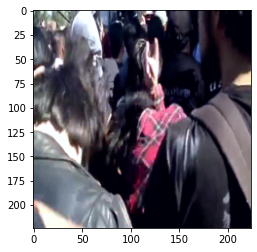

In [37]:
infer(10, model, tokenizer, dataloader, args)